In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 8]
set2 = [
    "#66c2a5",
    "#fc8d62",
    "#8da0cb",
    "#e78ac3",
    "#a6d854",
    "#ffd92f",
    "#e5c494",
    "#b3b3b3",
]  # Set2
colors = [set2[2], set2[3], set2[4]]

sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 3,
    },
    font_scale=3,
    palette=sns.color_palette("Set2")
)

In [25]:
LOW, HIGH = -6.5, -1.5
def truncate_trace(trace, threshold = -7):
    condition = trace < threshold
    counts = np.cumsum(condition)
    idx = np.searchsorted(counts, 3)
    trace = trace[:idx]

    return trace

def clean_data(data, labels):
    data = np.log10(data)
    hists_1d = []
    hists_2d = []
    clean_traces, unfiltered_traces = [], []
    new_labels = []
    feature_set = []
    for trace, label in zip(data, labels):
        tmp = trace.copy()
        trace = truncate_trace(trace, LOW)
        trace = trace[trace < HIGH]
        if len(trace) >= 0:
            clean_traces.append(trace)
            unfiltered_traces.append(tmp)

            hist1d, _ = np.histogram(trace, bins=96, range=(LOW, HIGH))
            H, *_ = np.histogram2d(np.arange(len(trace)), trace, bins=16, range=[[0, 1250], [LOW, HIGH]])
            hist2d = H.ravel()
            hists_2d.append(hist2d)
            hists_1d.append(hist1d)

            new_labels.append(label)

    clean_traces = np.array(clean_traces)
    unfiltered_traces = np.array(unfiltered_traces)
    hists_1d = np.array(hists_1d)
    hists_2d = np.array(hists_2d)
    new_labels = np.array(new_labels)
    feature_set = np.array(feature_set)
    return hists_1d, hists_2d, clean_traces, unfiltered_traces, new_labels, feature_set

def split(x, y, test_size=0.2, random_state=None):
    from sklearn.model_selection import ShuffleSplit
    sss = ShuffleSplit(
        n_splits=1,
        test_size=test_size,
        random_state=random_state
    )

    sss.get_n_splits(x, y)
    train_index, test_index = next(sss.split(x, y))

    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    return x_train, x_test, y_train, y_test, train_index, test_index

def low_align(trace):
    low_threshold = np.argmax(trace < -5)
    upper_idx = max(0, low_threshold - 1200)
    lower_idx = min(len(trace), low_threshold + 110)
    xaxis = np.arange(upper_idx, lower_idx)
    trace = trace[upper_idx:lower_idx]
    return xaxis, trace

def create_combined_plot(traces, ax_2d, ax_1d, **kwargs):
    low, high = -6, .5
    hists_2d = []
    hists_1d = []
    for trace in traces:
        xaxis, trace = low_align(trace)
        H, *_ = np.histogram2d(
            trace,
            np.arange(len(trace)),
            bins=256,
            range=[[low, high], [0, len(trace)]]
        )
        hists_2d.append(H)

        counts, binedges = np.histogram(trace, bins=256, range=(low, high))
        hists_1d.append(counts)
    hists_2d = np.array(hists_2d)
    hists_1d = np.array(hists_1d)
    binedges = (binedges[1:] + binedges[:-1])/2

    end = 110
    end *= 0.00065  # nM
    end *= 10  # Ang
    start = -1200
    start *= 0.00065  # nM
    start *= 10  # Ang

    im = ax_2d.imshow(
        hists_2d.sum(axis=0),
        extent=[start, end, low, high],
        aspect="auto",
        origin="lower",
        cmap="viridis",
        vmin=0,
        vmax=128,
    )
    ax_1d.plot(hists_1d.sum(axis=0), binedges, **kwargs)
    return im

In [66]:
data = np.load("./all_traces.npy", allow_pickle=True)
labels = np.genfromtxt("./Labels.txt")
data = data[labels != -1]
labels = labels[labels != -1]

hists_1d, hists_2d, clean_traces, unfiltered_traces, labels, feature_set = clean_data(data, labels)

/tmp/ipykernel_42819/4120168225.py:11: RuntimeWarning: invalid value encountered in log10
  data = np.log10(data)
/tmp/ipykernel_42819/4120168225.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clean_traces = np.array(clean_traces)


In [67]:
print(f"Molecular traces: {len(labels[labels == 1])}")
print(f"Tunneling traces: {len(labels[labels == 0])}")

Molecular traces: 1863
Tunneling traces: 3219


In [68]:
balance = True
if balance:
    sorted_labels_indices = np.argsort(labels)[::-1]  # molecular first
    sorted_hists_1d = hists_1d[sorted_labels_indices]
    balanced_hists_1d = sorted_hists_1d[:len(labels[labels == 1])*2]

    sorted_hists_2d = hists_2d[sorted_labels_indices]
    balanced_hists_2d = sorted_hists_2d[:len(labels[labels == 1])*2]
    
    sorted_labels = labels[sorted_labels_indices]
    balanced_labels = sorted_labels[:len(labels[labels == 1])*2]
    
    sorted_unfiltered = unfiltered_traces[sorted_labels_indices]
    balanced_unfiltered = sorted_unfiltered[:len(labels[labels == 1])*2]

    sorted_clean = clean_traces[sorted_labels_indices]
    balanced_clean = sorted_clean[:len(labels[labels == 1])*2]

    hists_1d = balanced_hists_1d
    hists_2d = balanced_hists_2d
    labels = balanced_labels
    unfiltered_traces = balanced_unfiltered
    clean_traces = balanced_clean

In [69]:
from sklearn.linear_model import LogisticRegressionCV

train_x, test_x, train_y, test_y, train_indices, test_indices = split(
    hists_2d, labels, test_size=.6, random_state=42,
)

print(f"Training examples: {len(train_indices)}")

model = LogisticRegressionCV(cv=5, max_iter=512, penalty="l2", solver="liblinear")
model.fit(train_x, train_y)

y_pred = model.predict_proba(test_x)
print(f"AUROC: {metrics.roc_auc_score(test_y, y_pred[:, 1])}")
print(f"Accuracy: {metrics.accuracy_score(test_y, model.predict(test_x))}")

Training examples: 1490
AUROC: 0.992916353278177
Accuracy: 0.9660107334525939


In [70]:
def labels_at_threshold(y_pred, threshold):
    labels = np.empty_like(y_pred)
    labels[y_pred >= threshold] = 1
    labels[y_pred < threshold] = 0

    return labels

def metric_at_every_threshold(metric, thresholds, test_y, pred_y):
    metric_results = []
    for thresh in thresholds:
        metric_results.append(metric(test_y, labels_at_threshold(pred_y, thresh)))
    return np.array(metric_results)

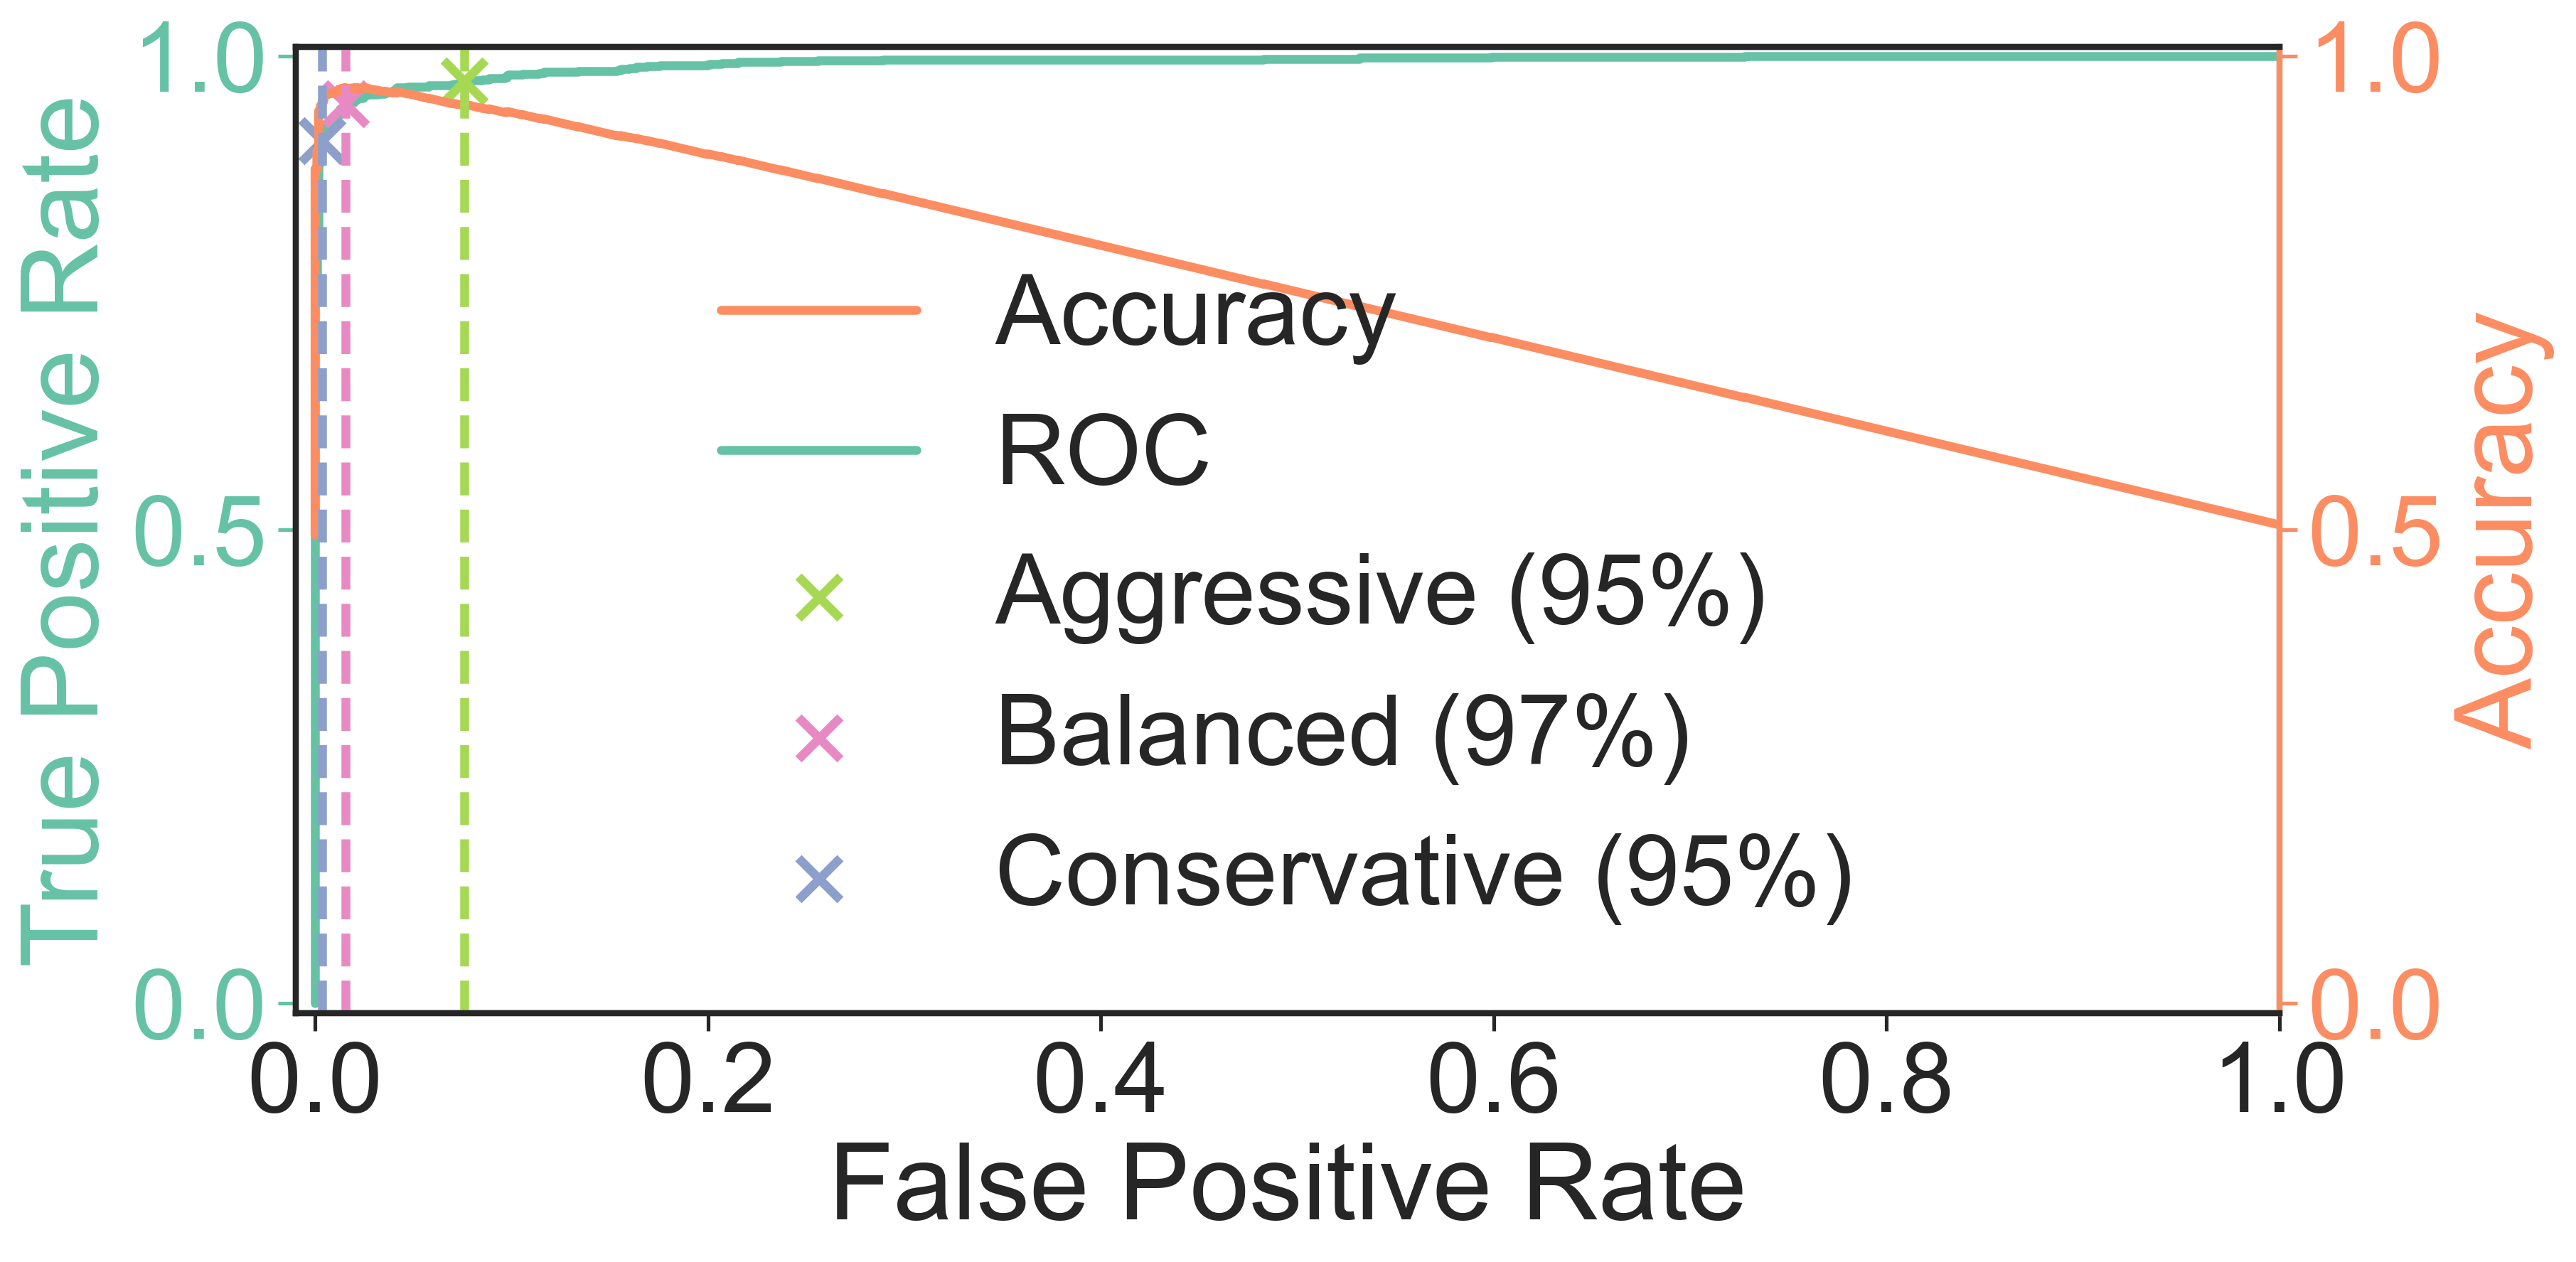

In [71]:
fig, ax = plt.subplots(sharex=True, sharey=True, dpi=300, figsize=(12, 6))

fpr, tpr, thresholds = metrics.roc_curve(test_y, y_pred[:, 1])
ax.plot(fpr, tpr, label="ROC", c=set2[0])

accuracy = metric_at_every_threshold(metrics.accuracy_score, thresholds, test_y, y_pred[:, 1])
ax1 = ax.twinx()
ax1.plot(fpr, accuracy, label="Accuracy", c=set2[1])

# balanced data set
best_idx = np.argmax(tpr - fpr)
upper_idx = best_idx + 32
lower_idx = 10

sequential = ["#af8dc3", "#3D3D3D", "#7fbf7b"]

ax1.scatter(fpr[upper_idx], tpr[upper_idx], marker="x", c=set2[4], s=200, label=f"Aggressive ({int(np.round(accuracy[upper_idx]*100, 0))}%)")
ax1.axvline(fpr[upper_idx], linestyle="--", c=set2[4])

ax1.scatter(fpr[best_idx], tpr[best_idx], marker="x", c=set2[3], s=200, label=f"Balanced ({int(np.round(accuracy[best_idx]*100, 0))}%)")
ax1.axvline(fpr[best_idx], linestyle="--", c=set2[3])

ax1.scatter(fpr[lower_idx], tpr[lower_idx], marker="x", c=set2[2], s=200, label=f"Conservative ({int(np.round(accuracy[lower_idx]*100, 0))}%)")
ax1.axvline(fpr[lower_idx], linestyle="--", c=set2[2])

# Dummy graph to include ROC in the legend
ax1.plot([0], [0], label="ROC", c=set2[0])
ax1.legend(frameon=False, loc="lower center")

ax.set_xlim(-.01, 1)
ax.set_ylim(-.01, 1.01)
ax1.set_xlim(-.01, 1)
ax1.set_ylim(-.01, 1.01)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate", c=set2[0])
ax.spines['right'].set_color(set2[0])
ax.tick_params(axis='y', colors=set2[0])

ax1.set_ylabel("Accuracy", c=set2[1])
ax1.spines['right'].set_color(set2[1])
ax1.tick_params(axis='y', colors=set2[1])
plt.savefig("./roc_accuracy.pdf")
plt.show()

In [72]:
print(f"Conservative threshold FPR: {fpr[lower_idx]:.4}")
print(f"Balanced threshold FPR: {fpr[best_idx]:.4}")
print(f"Aggressive threshold FPR: {fpr[upper_idx]:.4}")

print("="*25)

print(f"Conservative threshold TPR: {tpr[lower_idx]:.4}")
print(f"Balanced threshold TPR: {tpr[best_idx]:.4}")
print(f"Aggressive threshold TPR: {tpr[upper_idx]:.4}")

Conservative threshold FPR: 0.003617
Balanced threshold FPR: 0.01537
Aggressive threshold FPR: 0.07595
Conservative threshold TPR: 0.9106
Balanced threshold TPR: 0.9496
Aggressive threshold TPR: 0.9735


In [73]:
full_pred = model.predict_proba(test_x)

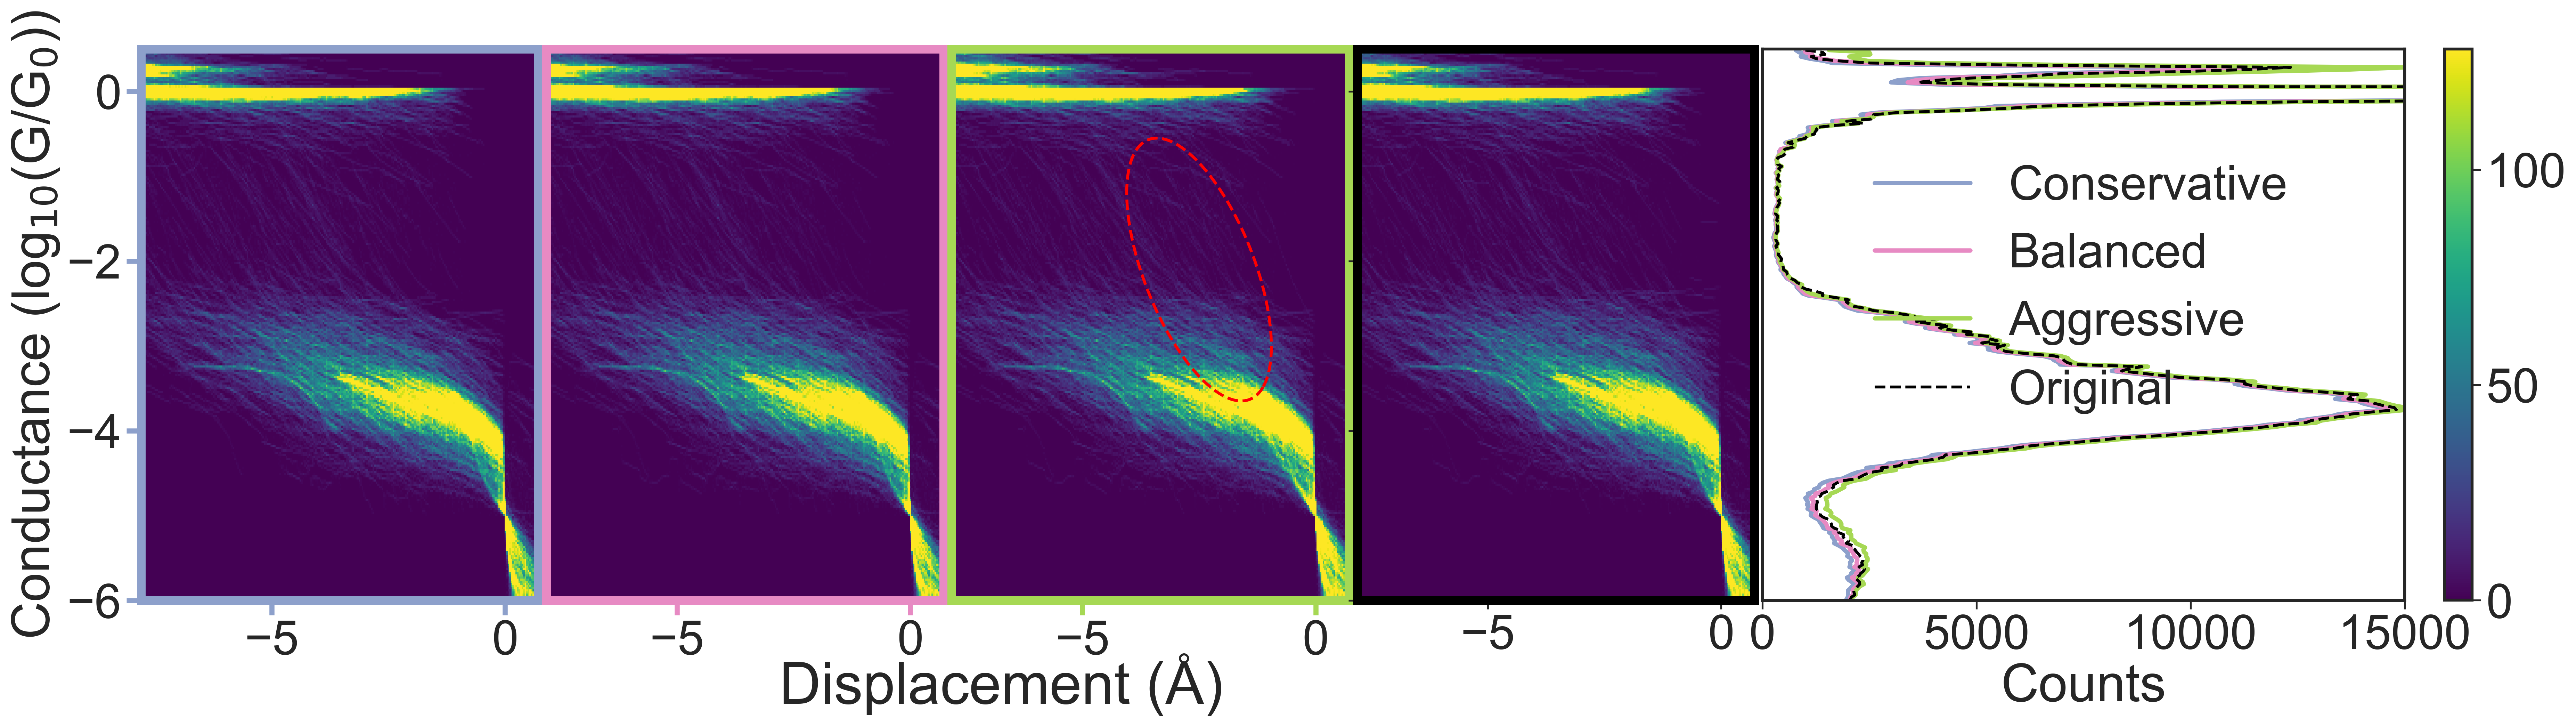

In [74]:
fig, axes = plt.subplots(1, 6, sharey=True, figsize=(30, 7), dpi=300)
gs = axes[4].get_gridspec()
# remove the underlying axes
axes[4].remove()
axes[5].remove()
axbig = fig.add_subplot(gs[4:], sharey=axes[1])

names = ["Conservative", "Balanced", "Aggressive"]
for idx, (ax, t) in enumerate(zip(axes, [lower_idx, best_idx, upper_idx])):
    thresholded_labels = labels_at_threshold(full_pred[:, 1], thresholds[t])
    im = create_combined_plot(
        unfiltered_traces[test_indices][thresholded_labels == 1],
        ax,
        axbig,
        label=names[idx],
        c=set2[2 + idx],
    )
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_edgecolor(colors[idx])
        ax.spines[axis].set_linewidth(6)
    ax.tick_params(axis='both', which='major', width=3.5, length=10, color=colors[idx])
    
im = create_combined_plot(
    unfiltered_traces[test_indices][labels[test_indices] == 1],
    axes[3],
    axbig,
    label="Original",
    c="k",
    linestyle="--",
    linewidth=2,
)
for axis in ['top','bottom','left','right']:
    axes[3].spines[axis].set_edgecolor("k")
    axes[3].spines[axis].set_linewidth(6)
ax.tick_params(axis='both', which='major', width=3.5, length=10)

axes[1].axes.get_yaxis().set_visible(False)
axes[2].axes.get_yaxis().set_visible(False)

fig.colorbar(im, ax=axbig)
plt.subplots_adjust(wspace=0.02)
axbig.legend(frameon=False, loc="upper right", bbox_to_anchor=(0.825, .78), bbox_transform=fig.transFigure)
axbig.set_xlabel("Counts")
axbig.set_xlim(0, 15_000)
axbig.axes.get_yaxis().set_visible(False)
axes[0].set_ylabel(r"Conductance (log$_{10}$(G/G$_0$))")
fig.text(0.4, 0.01, "Displacement (Å)", ha="center", va="center")

from matplotlib import patches
ellipsis = patches.Ellipse((-2.5, -2.1), width=2, height=3.9, angle=45, linewidth=2, linestyle="--", edgecolor="r", facecolor="none")
axes[2].add_patch(ellipsis)

plt.show()

## Length distributions

In [75]:
from scipy import stats

# Normalized Gaussian:
def gauss_pdf(x, mu, sigma):
    return stats.norm.pdf(x, mu, sigma)

def fit_gauss(x, mu, sigma, N_sig):
    return N_sig * gauss_pdf(x, mu, sigma)

5.053 ± 1.987
4.969 ± 1.994
4.868 ± 1.974
True: 4.937 ± 1.981


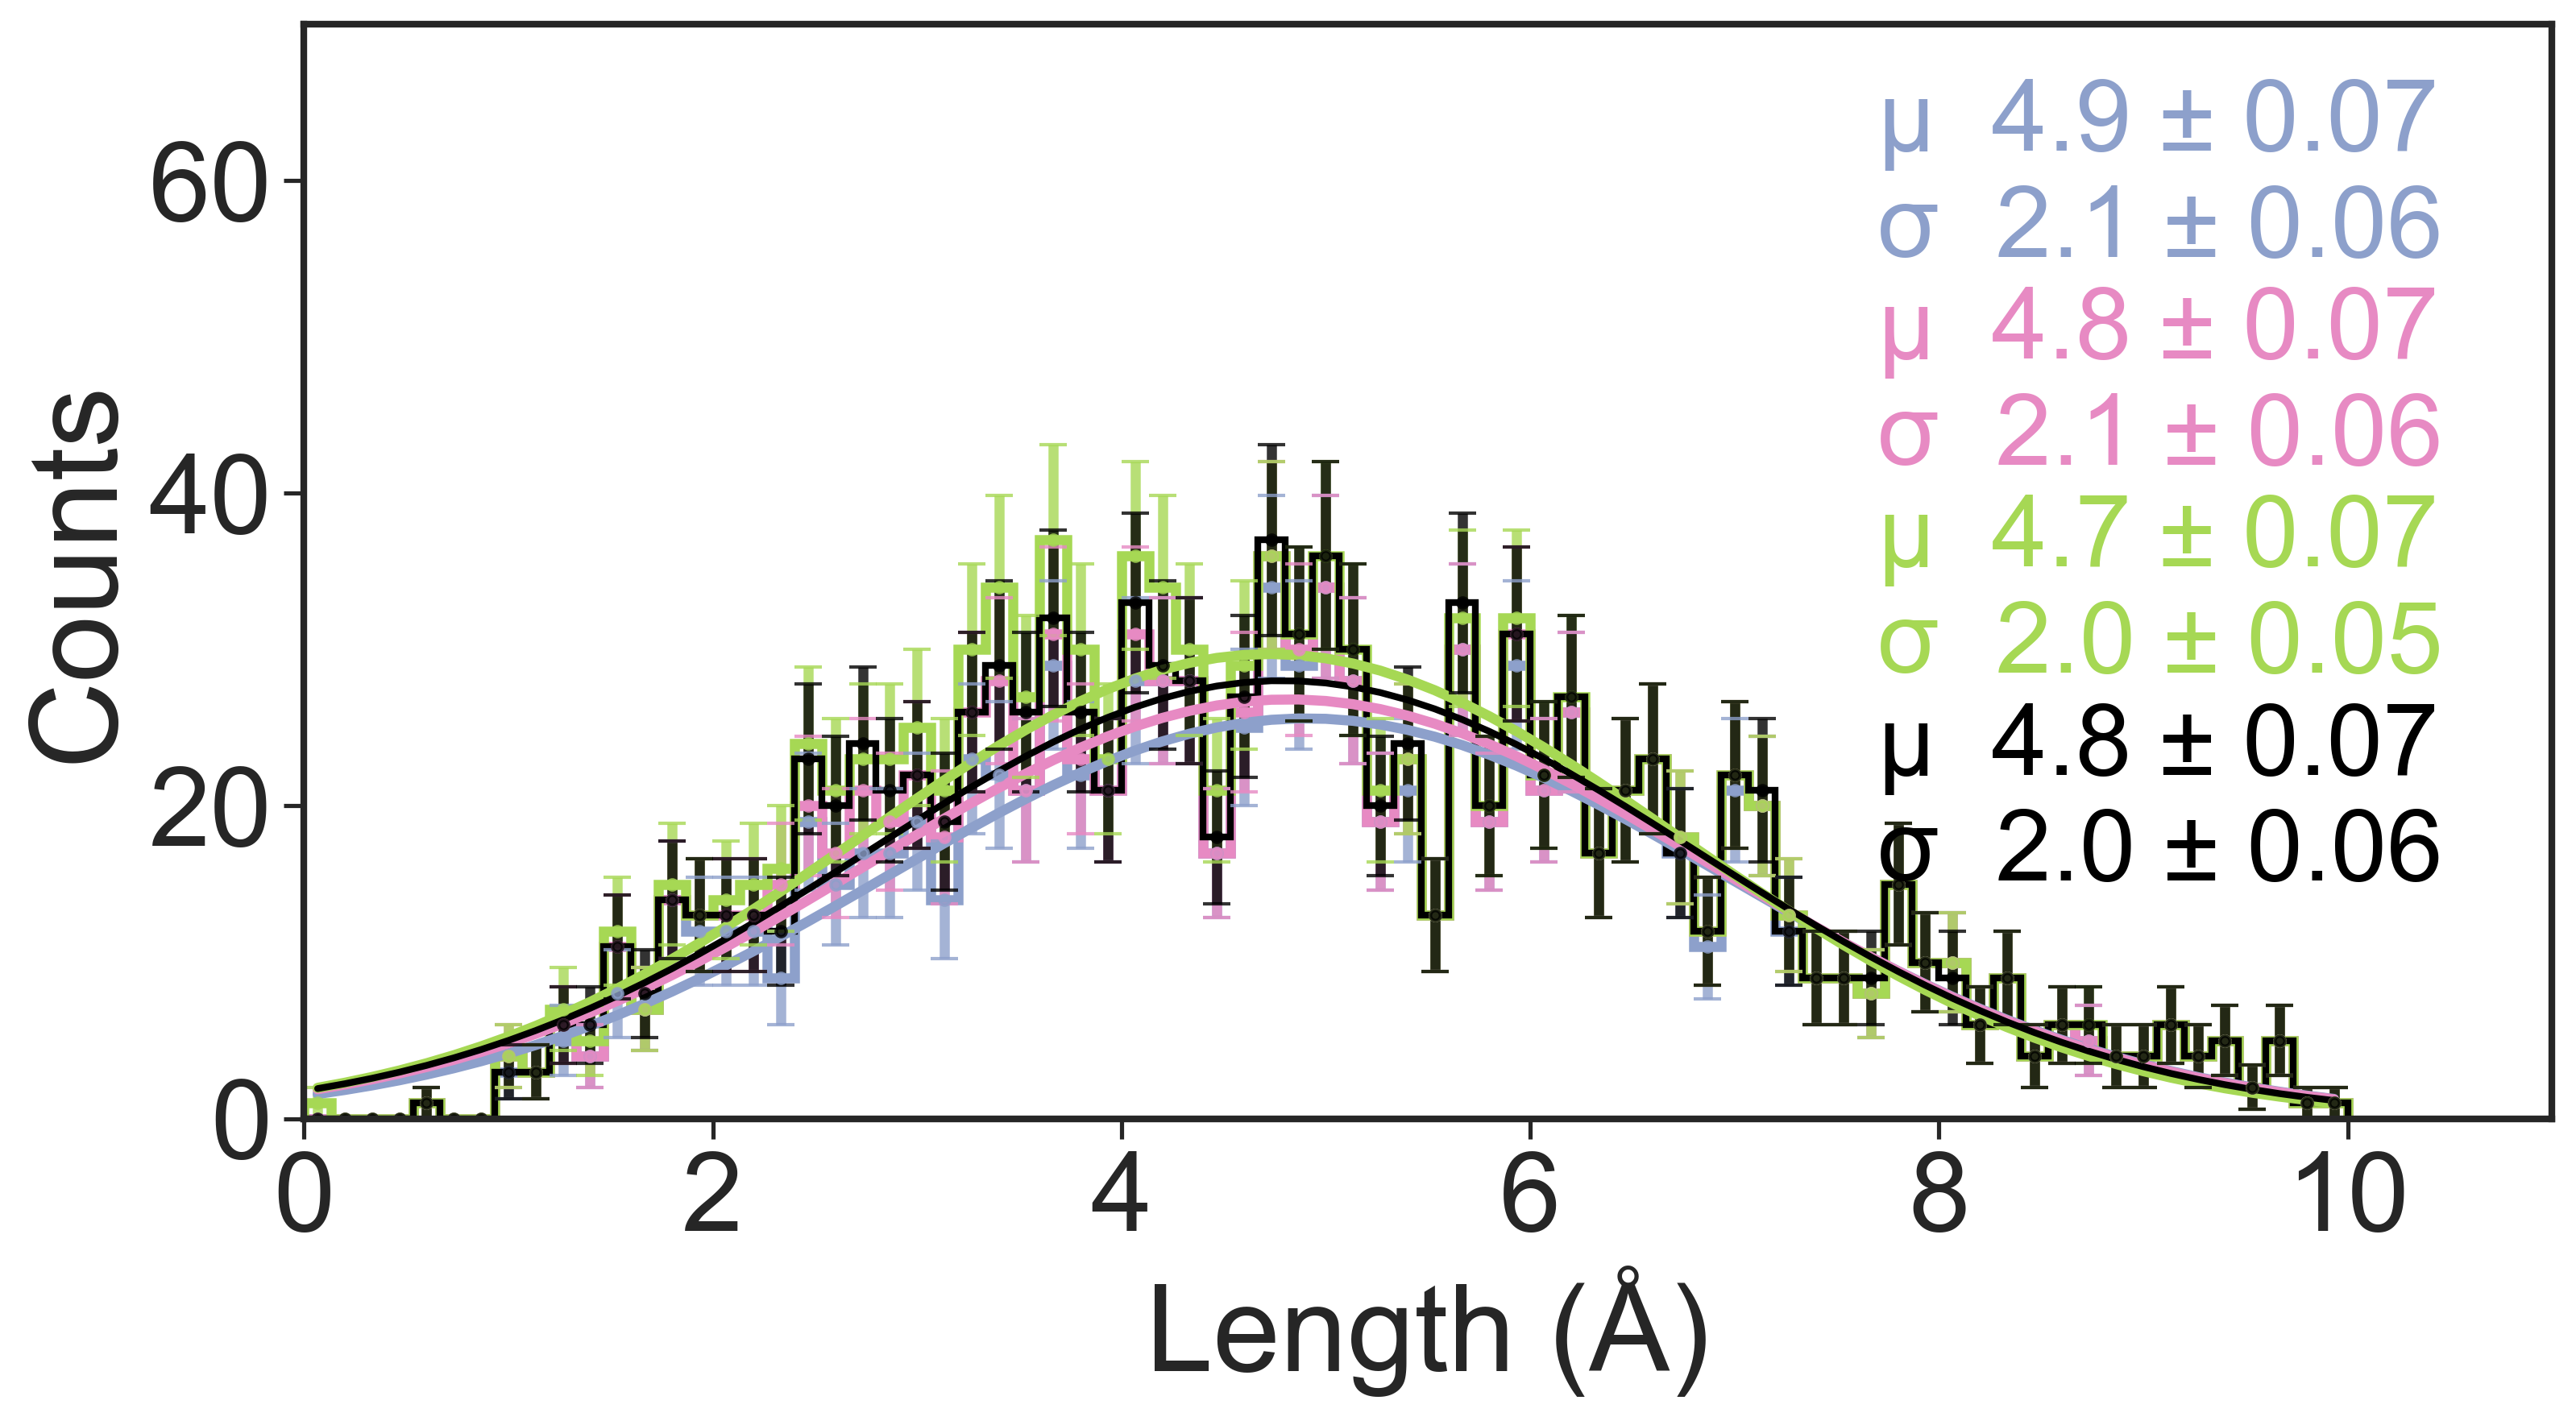

In [76]:
import sys
sys.path.append('./External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output

from iminuit import Minuit


result = []
fig, ax = plt.subplots(dpi=300, figsize=(12, 6))
distributions = []
for idx, thresh in enumerate([lower_idx, best_idx, upper_idx]):
    thresholded_labels = labels_at_threshold(full_pred[:, 1], thresholds[thresh])

    moleculars = clean_traces[test_indices][thresholded_labels == 1]
    lengths = np.array([len(x) for x in moleculars])
    lengths = lengths * 0.00065  # nM
    lengths *= 10  # Ang
    distributions.append(lengths)

    count, binedges, _ = ax.hist(lengths, bins=75, range=(0.0, 10), histtype="step", linewidth=3, color=colors[idx])
    binedges = (binedges[1:] + binedges[:-1])/2
    ax.errorbar(binedges, count, yerr=np.sqrt(count), c=colors[idx], fmt=".", capsize=4, alpha=0.8)
    sy = np.sqrt(count)
    chi2reg = Chi2Regression(fit_gauss, binedges[count>0], count[count>0], sy[count>0])
    minuit_cs = Minuit(chi2reg, pedantic=False, print_level=0, mu=np.mean(lengths), sigma=np.std(lengths, ddof=1), N_sig=100)
    minuit_cs.migrad()
    fit_mu, fit_sigma, fit_N_sig = minuit_cs.args

    ax.plot(binedges, fit_gauss(binedges, fit_mu, fit_sigma, fit_N_sig), c=colors[idx])
    print(f"{np.mean(lengths):.4} ± {np.std(lengths, ddof=1):.4}")

    Ndof_cs = len(count[count>0]) - len(minuit_cs.args)
    d = {
        "µ": f"{minuit_cs.values['mu']:.2} ± {minuit_cs.errors['mu']:.1}",
        "σ": f"{minuit_cs.values['sigma']:.2} ± {minuit_cs.errors['sigma']:.1}",
        # "Prob": f"{stats.chi2.sf(minuit_cs.fval, Ndof_cs):.4}",
    }
    nice_string = nice_string_output(d, 2)
    ax.text(
        0.7, 0.95 - idx*0.19, nice_string, transform=ax.transAxes, fontsize=30, color=colors[idx], verticalalignment='top'
    )


moleculars = clean_traces[test_indices][labels[test_indices] == 1]
lengths = np.array([len(x) for x in moleculars])
lengths = lengths * 0.00065  # nM
lengths *= 10  # Ang
distributions.append(lengths)

count, binedges, _ = ax.hist(lengths, bins=75, range=(0.0, 10), histtype="step", linewidth=2, color="k")
binedges = (binedges[1:] + binedges[:-1])/2
ax.errorbar(binedges, count, yerr=np.sqrt(count), c="k", fmt=".", capsize=4, alpha=0.8)
sy = np.sqrt(count)
chi2reg = Chi2Regression(fit_gauss, binedges[count>0], count[count>0], sy[count>0])
minuit_cs = Minuit(chi2reg, pedantic=False, print_level=0, mu=np.mean(lengths), sigma=np.std(lengths, ddof=1), N_sig=100)
minuit_cs.migrad()
fit_mu, fit_sigma, fit_N_sig = minuit_cs.args

ax.plot(binedges, fit_gauss(binedges, fit_mu, fit_sigma, fit_N_sig), c="k", linewidth=2)
print(f"True: {np.mean(lengths):.4} ± {np.std(lengths, ddof=1):.4}")

Ndof_cs = len(count[count>0]) - len(minuit_cs.args)
d = {
    "µ": f"{minuit_cs.values['mu']:.2} ± {minuit_cs.errors['mu']:.1}",
    "σ": f"{minuit_cs.values['sigma']:.2} ± {minuit_cs.errors['sigma']:.1}",
    # "Prob": f"{stats.chi2.sf(minuit_cs.fval, Ndof_cs):.4}",
}
nice_string = nice_string_output(d, 2)
ax.text(
    0.7, 0.95 - (idx + 1)*0.19, nice_string, transform=ax.transAxes, fontsize=30, color="k", verticalalignment='top'
)

ax.set_ylim(0, 70)
ax.set_xlim(0, 11)
ax.set_ylabel("Counts")
ax.set_xlabel("Length (Å)")
plt.show()